In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-data/question4-stock-data.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy import stats
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [4]:
df = pd.read_csv('/kaggle/input/stock-data/question4-stock-data.csv')
df.head(10)

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
0,0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0
1,1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0
2,2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0
3,3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0
4,4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0
5,5,1980-03-24,2.371490,3.398259,3.451775,3.398259,0.000000,2803.0
6,6,1980-03-25,2.352816,3.371501,3.425017,3.371501,0.000000,27095.0
7,7,1980-03-26,2.352816,3.371501,3.425017,3.371501,0.000000,1869.0
8,8,1980-03-27,2.324807,3.331364,3.384880,3.331364,0.000000,14015.0
9,9,1980-03-28,2.315470,3.317985,3.371501,3.317985,0.000000,36438.0


In [5]:
print(df.head())

   Unnamed: 0        Date  Adj Close     Close      High       Low      Open  \
0           0  1980-03-17   2.296798  3.291227  3.344743  3.291227  0.000000   
1           1  1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000   
2           2  1980-03-19   2.306134  3.304606  3.304606  3.304606  3.304606   
3           3  1980-03-20   2.306134  3.304606  3.358122  3.304606  0.000000   
4           4  1980-03-21   2.362154  3.384880  3.438396  3.384880  0.000000   

    Volume  
0  41109.0  
1   9343.0  
2      0.0  
3  10277.0  
4   8409.0  


In [6]:
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
Unnamed: 0      0
Date          110
Adj Close      93
Close         117
High           95
Low           127
Open          103
Volume        145
dtype: int64


### Handle Missing Values

In [7]:
# Drop rows with missing Date values
df = df.dropna(subset=['Date'])
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.drop(['Unnamed: 0'], axis=1)

In [8]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11181 entries, 1980-03-17 to 2024-12-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  11088 non-null  float64
 1   Close      11065 non-null  float64
 2   High       11086 non-null  float64
 3   Low        11055 non-null  float64
 4   Open       11081 non-null  float64
 5   Volume     11036 non-null  float64
dtypes: float64(6)
memory usage: 611.5 KB


In [9]:
# Fill missing values
for col in ["Adj Close", "Close", "High", "Low", "Open"]:
    df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

# Fill missing Volume with 0
if "Volume" in df.columns:
    df["Volume"].fillna(0, inplace=True)


In [10]:
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


### Exploratory Data Analysis

In [11]:
 # Basic statistics
print("\nBasic statistics:")
print(df.describe())


Basic statistics:
          Adj Close         Close          High           Low          Open  \
count  11181.000000  11181.000000  11181.000000  11181.000000  11181.000000   
mean      63.668077     72.126528     72.548109     71.712502     68.018510   
std       52.350679     51.362731     51.620587     51.043881     55.922053   
min        2.259452      3.237711      3.237711      3.237711      0.000000   
25%       19.224636     27.548208     27.735613     27.548208      0.000000   
50%       50.615738     66.062500     66.660004     65.470001     66.000000   
75%      104.843605    114.400002    114.980003    113.680000    114.500000   
max      254.770004    254.770004    255.229996    253.589996    255.000000   

             Volume  
count  1.118100e+04  
mean   2.119053e+05  
std    3.873541e+05  
min    0.000000e+00  
25%    1.260000e+04  
50%    8.530000e+04  
75%    2.894000e+05  
max    1.858270e+07  


In [12]:
# Check for stationarity
print("\nAugmented Dickey-Fuller Test for 'Close':")
result = adfuller(df['Close'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


Augmented Dickey-Fuller Test for 'Close':
ADF Statistic: -0.4874235020891138
p-value: 0.8944474378213645


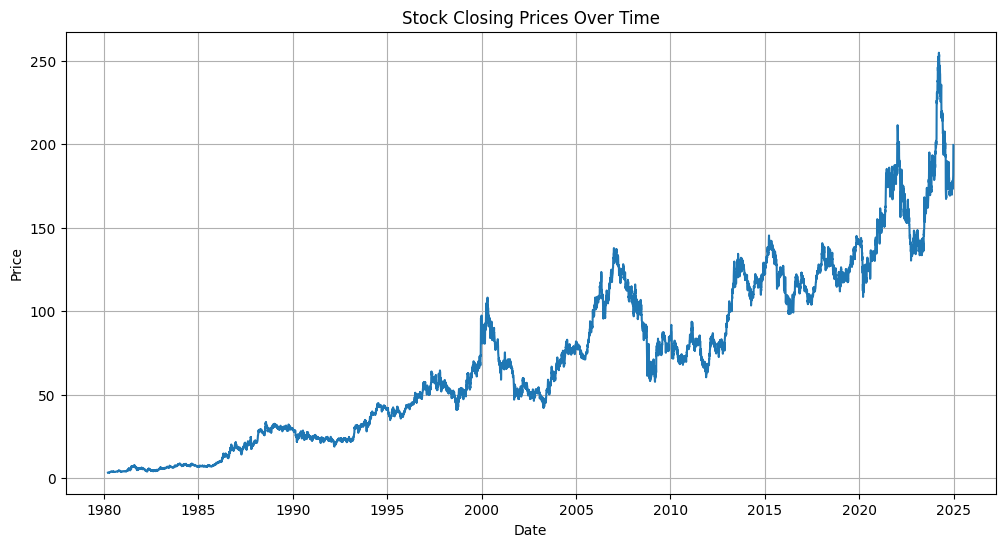

In [13]:
# Plot the closing prices
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'])
plt.title('Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

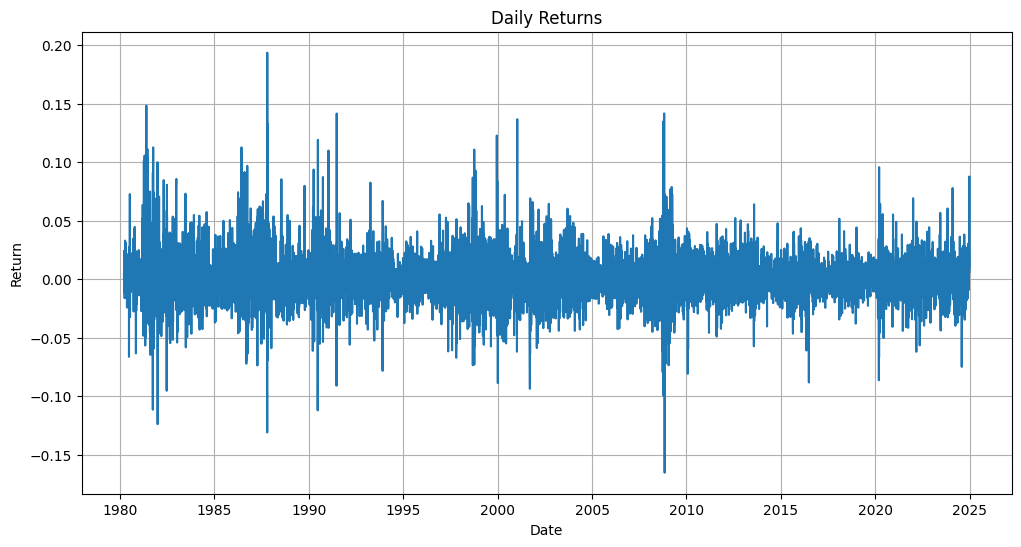

In [14]:
# Plot daily returns
df['Daily_Return'] = df['Close'].pct_change()
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Daily_Return'])
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)

Text(0.5, 1.0, 'Distribution of Daily Returns')

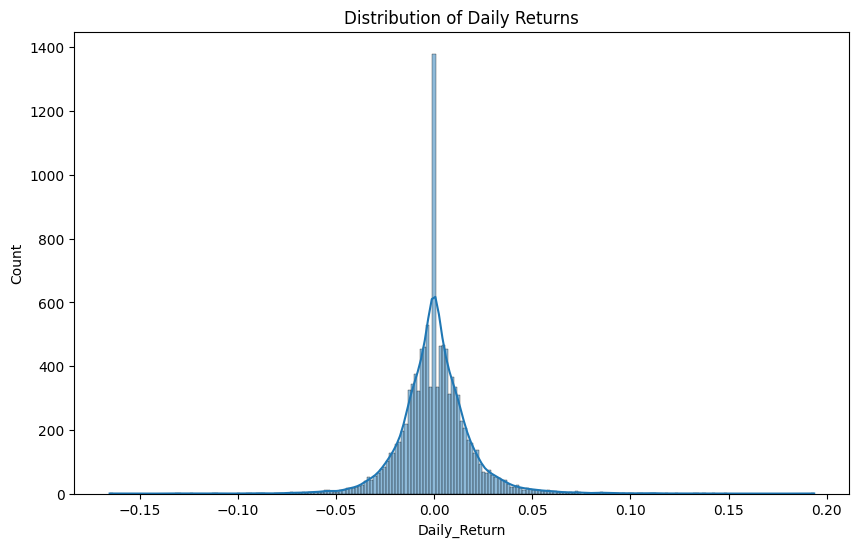

In [15]:
# Distribution of returns
plt.figure(figsize=(10, 6))
sns.histplot(df['Daily_Return'].dropna(), kde=True)
plt.title('Distribution of Daily Returns')

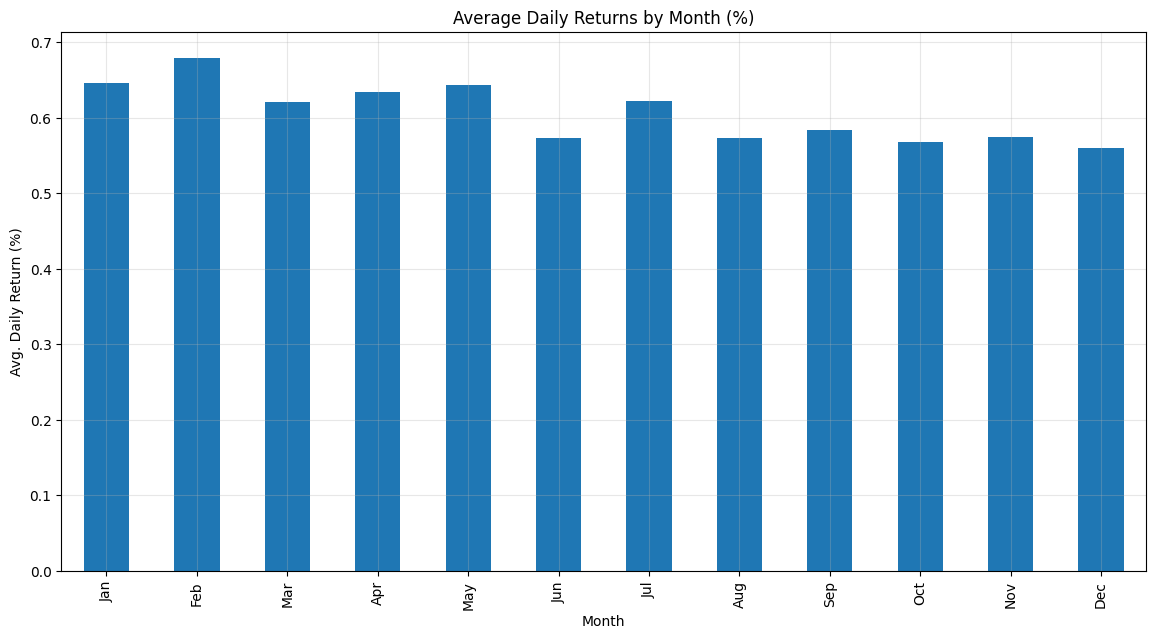

In [16]:
df['Month'] = df.index.month
df['DayOfWeek'] = df.index.dayofweek

# Monthly seasonal effect
monthly_returns = df.groupby('Month')['Close'].apply(
    lambda x: x.pct_change().mean() * 100
)

plt.figure(figsize=(14, 7))
monthly_returns.plot(kind='bar')
plt.title('Average Daily Returns by Month (%)')
plt.xlabel('Month')
plt.ylabel('Avg. Daily Return (%)')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, alpha=0.3)

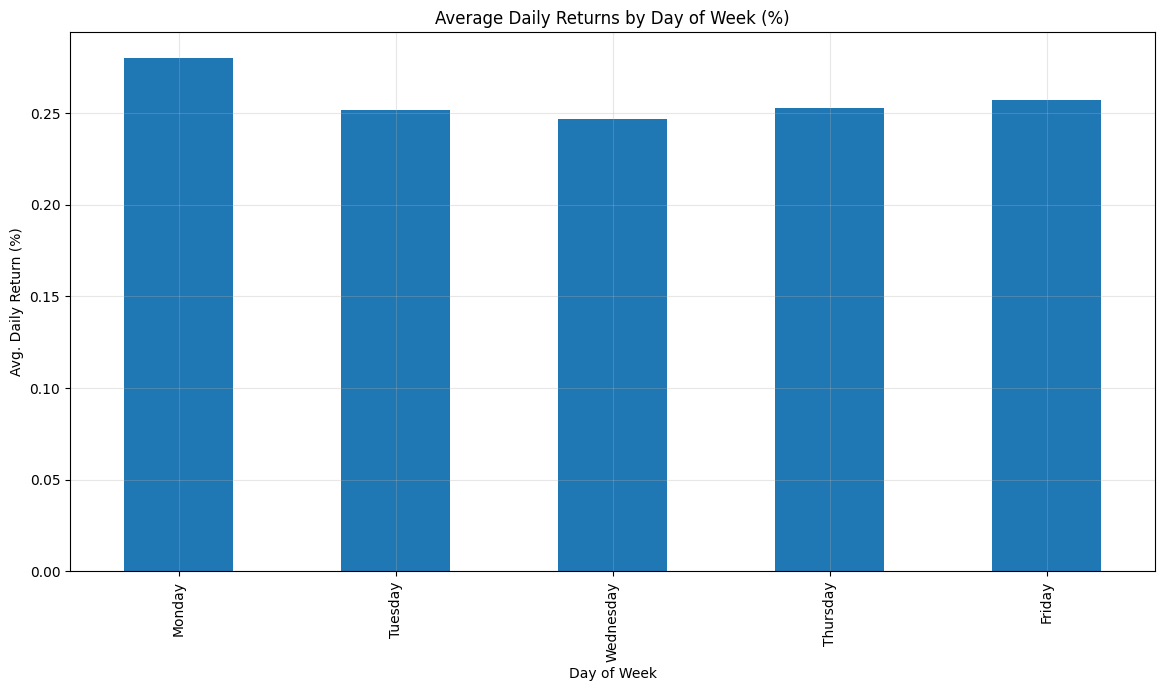

In [17]:
dow_returns = df.groupby('DayOfWeek')['Close'].apply(
    lambda x: x.pct_change().mean() * 100
)

plt.figure(figsize=(14, 7))
dow_returns.plot(kind='bar')
plt.title('Average Daily Returns by Day of Week (%)')
plt.xlabel('Day of Week')
plt.ylabel('Avg. Daily Return (%)')
plt.xticks(range(5), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.grid(True, alpha=0.3)

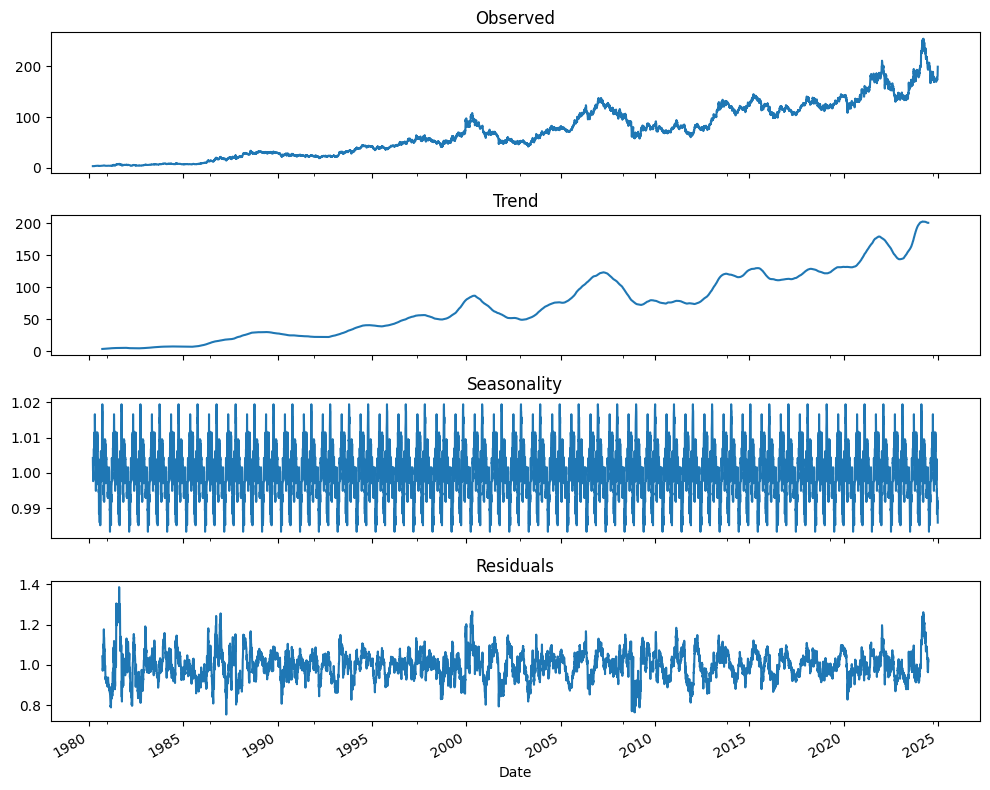

In [18]:
# Seasonal decomposition
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=252)
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

decomposition.observed.plot(ax=axes[0], title="Observed")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality")
decomposition.resid.plot(ax=axes[3], title="Residuals")

plt.tight_layout()
plt.show()

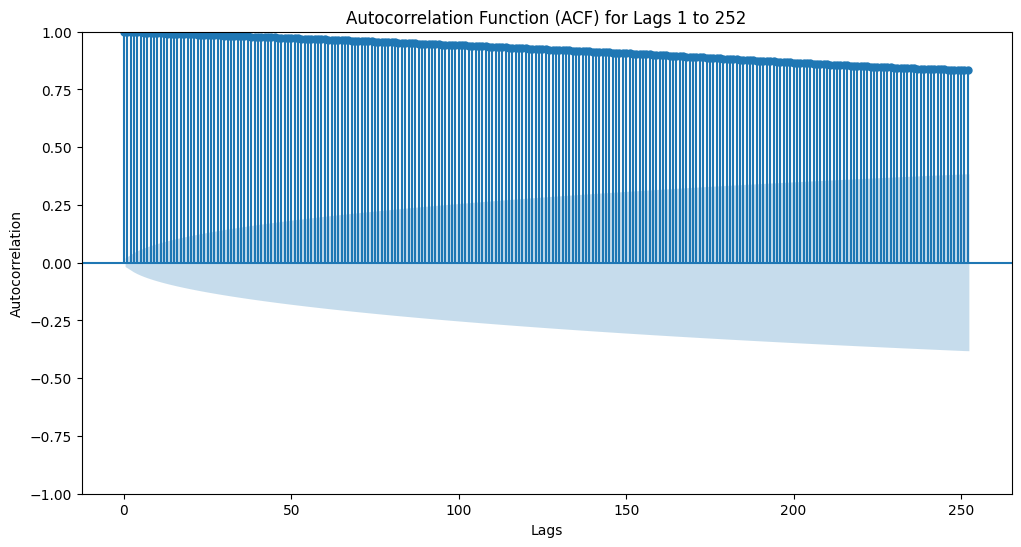

In [19]:
# Plot ACF for lags 1 to 252
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(df["Close"], lags=252, ax=ax)

plt.title("Autocorrelation Function (ACF) for Lags 1 to 252")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

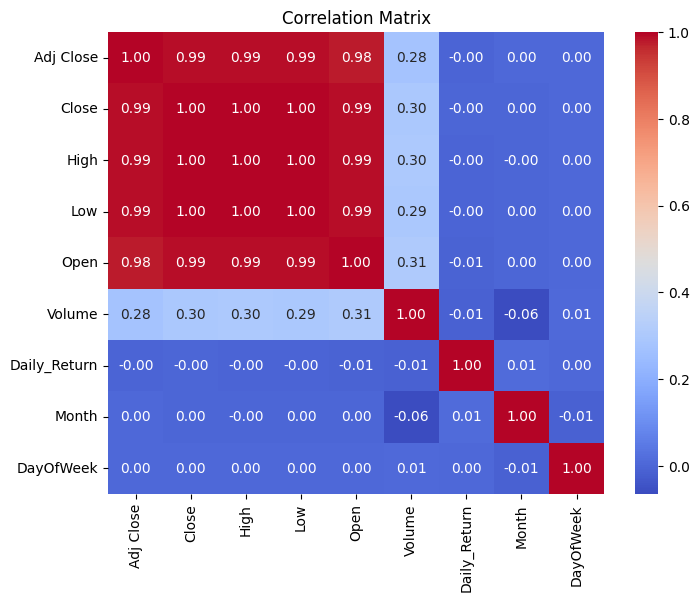

In [20]:
# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

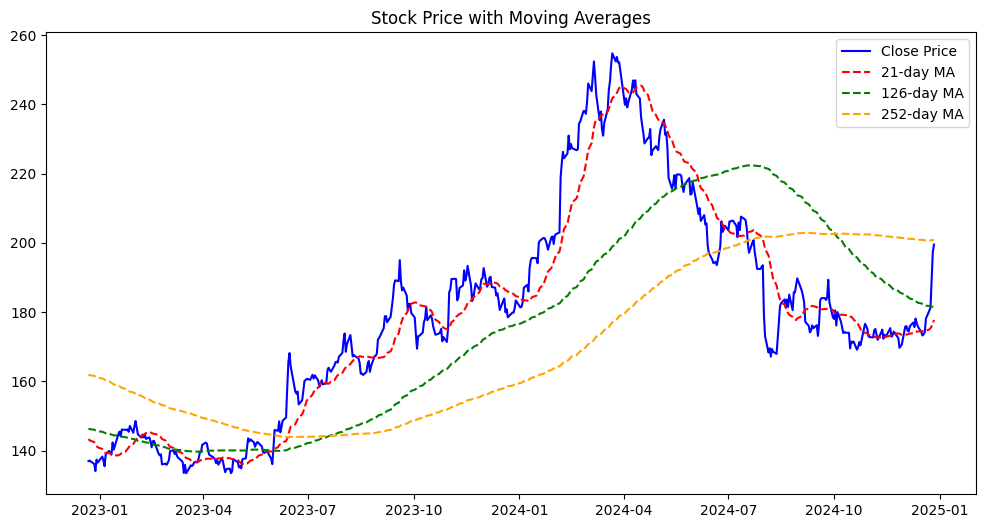

In [21]:
# Calculate Moving Averages
df['21-day MA'] = df['Close'].rolling(window=21).mean()
df['126-day MA'] = df['Close'].rolling(window=126).mean()
df['252-day MA'] = df['Close'].rolling(window=252).mean()

# Plot Moving Averages
plt.figure(figsize=(12,6))
plt.plot(df['Close'].tail(252*2), label='Close Price', color='blue')
plt.plot(df['21-day MA'].tail(252*2), label='21-day MA', color='red', linestyle="--")
plt.plot(df['126-day MA'].tail(252*2), label='126-day MA', color='green', linestyle="--")
plt.plot(df['252-day MA'].tail(252*2), label='252-day MA', color='orange', linestyle="--")
plt.title("Stock Price with Moving Averages")
plt.legend()
plt.show()


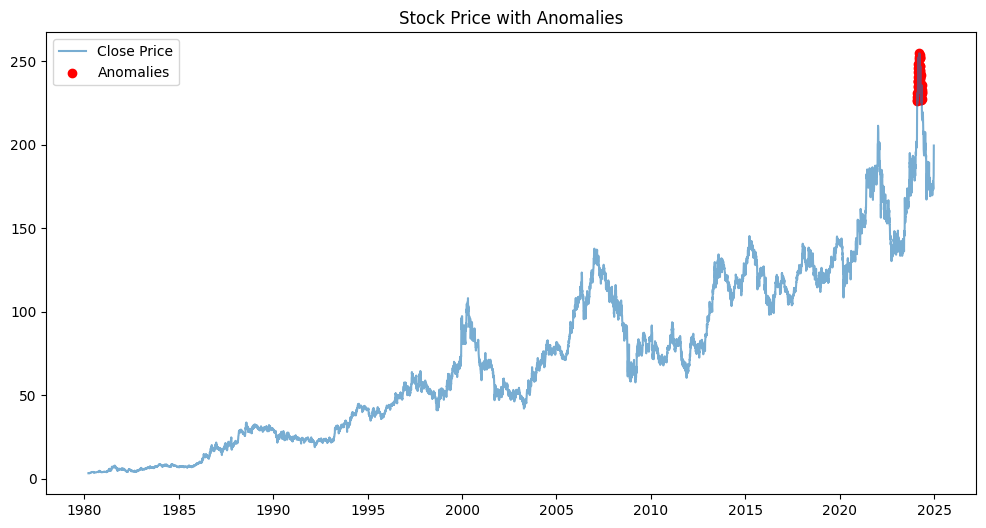

In [22]:
import numpy as np

# Compute Z-score
df['Z-Score'] = (df['Close'] - df['Close'].mean()) / df['Close'].std()

# Detect Anomalies (Threshold: ±3 standard deviations)
anomalies = df[np.abs(df['Z-Score']) > 3]

plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price', alpha=0.6)
plt.scatter(anomalies.index, anomalies['Close'], color='red', label='Anomalies', marker='o')
plt.title("Stock Price with Anomalies")
plt.legend()
plt.show()


### Model Building

In [23]:
# Drop highly correlated features

def drop_correlated_features(df, target, threshold=0.9):
    corr_matrix = df.corr()
    target_corr = corr_matrix[target]
    correlated_features = target_corr[target_corr > threshold].index.tolist()
    correlated_features.remove(target)
    df_dropped = df.drop(columns=correlated_features)
    return df_dropped

df = drop_correlated_features(df, 'Close')

In [24]:
# Handle missing value in the first row of Daily_Return
df['Daily_Return'].iloc[0] = df['Daily_Return'].iloc[1]

In [25]:
print(df.head())

               Close   Volume  Daily_Return  Month  DayOfWeek
Date                                                         
1980-03-17  3.291227  41109.0      0.004065      3          0
1980-03-18  3.304606   9343.0      0.004065      3          1
1980-03-19  3.304606      0.0      0.000000      3          2
1980-03-20  3.304606  10277.0      0.000000      3          3
1980-03-21  3.384880   8409.0      0.024292      3          4


In [26]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create Lag Features
def create_lags(df, lags=[1, 2, 3, 4, 5]):
    for lag in lags:
        df[f"Close_Lag_{lag}"] = df["Close"].shift(lag)
        df[f"Volume_Lag_{lag}"] = df["Volume"].shift(lag)
        df[f"Daily_Return_Lag_{lag}"] = df["Daily_Return"].shift(lag)
    return df

df = create_lags(df).dropna()

# Train-Test Split
eval_start = "2022-01-01"
train = df[df.index < eval_start]
test = df[df.index >= eval_start]

# Feature Selection
features = [col for col in df.columns if col not in ["Close"]]
X_train, y_train = train[features], train["Close"]
X_test, y_test = test[features], test["Close"]

# Custom Sinusoidal Regressor
class SinusoidalRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, freq=0.01):
        self.freq = freq
        self.model = LinearRegression()

    def fit(self, X, y):
        X_sin = np.hstack([X, np.sin(self.freq * X), np.cos(self.freq * X)])
        self.model.fit(X_sin, y)
        return self

    def predict(self, X):
        X_sin = np.hstack([X, np.sin(self.freq * X), np.cos(self.freq * X)])
        return self.model.predict(X_sin)

# Custom Boosted Hybrid Model
class BoostedHybrid(BaseEstimator, RegressorMixin):
    def __init__(self, model1, model2):
        self.model1 = model1
        self.model2 = model2

    def fit(self, X, y):
        # Sinusoidal features for model1
        X_sin = np.hstack([X, np.sin(0.01 * X), np.cos(0.01 * X)])
        
        # Fit first model (Sinusoidal Regressor)
        self.model1.fit(X_sin, y)

        # Compute residuals
        residuals = y - self.model1.predict(X_sin)

        # Fit second model (XGBoost) on residuals
        self.model2.fit(X, residuals)
        return self

    def predict(self, X):
        X_sin = np.hstack([X, np.sin(0.01 * X), np.cos(0.01 * X)])
        return self.model1.predict(X_sin) + self.model2.predict(X)

# Define Hybrid Model
hybrid_model = BoostedHybrid(
    model1=SinusoidalRegressor(freq=0.01),
    model2=xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.01, max_depth=7)
)

# Train Hybrid Model
hybrid_model.fit(X_train.values, y_train)

# Make Predictions
hybrid_preds = hybrid_model.predict(X_test.values)

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, hybrid_preds))
mae = mean_absolute_error(y_test, hybrid_preds)
mse = mean_squared_error(y_test, hybrid_preds)
mape = np.mean(np.abs((y_test - hybrid_preds) / y_test)) * 100
r2 = r2_score(y_test, hybrid_preds)

# Print Report
report = f"""
Hybrid Model Evaluation Report:
--------------------------------
RMSE  (Root Mean Squared Error): {rmse:.4f}
MAE   (Mean Absolute Error)    : {mae:.4f}
MSE   (Mean Squared Error)     : {mse:.4f}
MAPE  (Mean Absolute % Error)  : {mape:.4f}
R² Score (Coefficient of Determination): {r2:.4f}
"""

print(report)



Hybrid Model Evaluation Report:
--------------------------------
RMSE  (Root Mean Squared Error): 2.0516
MAE   (Mean Absolute Error)    : 0.8400
MSE   (Mean Squared Error)     : 4.2090
MAPE  (Mean Absolute % Error)  : 0.3973
R² Score (Coefficient of Determination): 0.9950



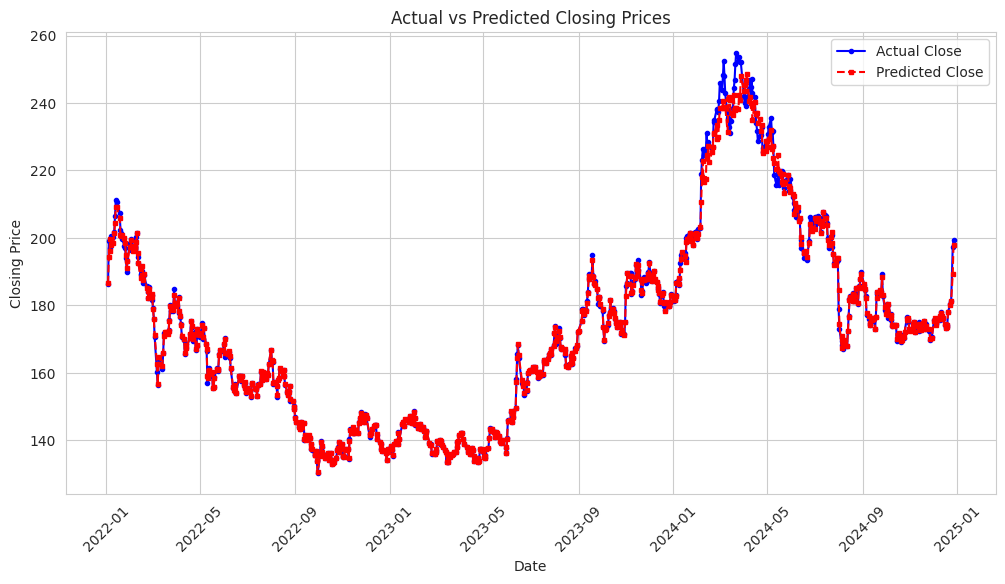

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a time index covering the entire test period
date_range = pd.date_range(start=test.index.min(), end=test.index.max(), freq="B")  # 'B' ensures only business days

# Ensure the test dataset aligns with the date range
actual_series = pd.Series(y_test.values, index=test.index)
predicted_series = pd.Series(hybrid_preds, index=test.index)

# Plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

plt.plot(actual_series, label="Actual Close", marker='o', markersize=3, linestyle="-", color="blue")
plt.plot(predicted_series, label="Predicted Close", marker='s', markersize=3, linestyle="--", color="red")

plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Actual vs Predicted Closing Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()


### Predict Future

In [28]:
# Recreate lag features on full dataset
df_full = create_lags(df).dropna()

# Define features and target for full training
X_full, y_full = df_full[features], df_full["Close"]

# Retrain Hybrid Model on full dataset
hybrid_model.fit(X_full.values, y_full)


BoostedHybrid(model1=SinusoidalRegressor(),
              model2=XGBRegressor(base_score=None, booster=None, callbacks=None,
                                  colsample_bylevel=None, colsample_bynode=None,
                                  colsample_bytree=None, device=None,
                                  early_stopping_rounds=None,
                                  enable_categorical=False, eval_metric=None,
                                  feature_types=None, gamma=None,
                                  grow_policy=None, importance_type=None,
                                  interaction_constraints=None,
                                  learning_rate=0.01, max_bin=None,
                                  max_cat_threshold=None,
                                  max_cat_to_onehot=None, max_delta_step=None,
                                  max_depth=7, max_leaves=None,
                                  min_child_weight=None, missing=nan,
                                  monotone_constraints=None,
                                  multi_strategy=None, n_estimators=500,
                                  n_jobs=None, num_parallel_tree=None,
                                  random_state=None, ...))

In [29]:
# Create a DataFrame for future dates
future_dates = pd.date_range(start="2024-12-30", periods=5, freq='B')
future_df = pd.DataFrame(index=future_dates)
future_df["Month"] = future_df.index.month
future_df["DayOfWeek"] = future_df.index.weekday

# Start with last known values from full dataset
last_known_values = df_full.iloc[-5:].copy()

# Iteratively predict the next 5 days
for date in future_df.index:
    for lag in range(1, 6):
        future_df.loc[date, f"Close_Lag_{lag}"] = last_known_values["Close"].iloc[-lag]
        future_df.loc[date, f"Volume_Lag_{lag}"] = last_known_values["Volume"].iloc[-lag]
        future_df.loc[date, f"Daily_Return_Lag_{lag}"] = last_known_values["Daily_Return"].iloc[-lag]

    # Estimate Volume & Daily Return (Using recent averages)
    future_df.loc[date, "Volume"] = last_known_values["Volume"].rolling(5).mean().iloc[-1]
    future_df.loc[date, "Daily_Return"] = last_known_values["Daily_Return"].rolling(5).mean().iloc[-1]

    # Prepare input and predict closing price
    X_future = future_df.loc[date][features].values.reshape(1, -1)
    future_df.loc[date, "Close"] = hybrid_model.predict(X_future)[0]

    last_known_values = pd.concat([last_known_values, future_df.loc[[date]]])

print(future_df[["Close"]])


                 Close
2024-12-30  205.284261
2024-12-31  211.281551
2025-01-01  217.834394
2025-01-02  225.010265
2025-01-03  231.127748


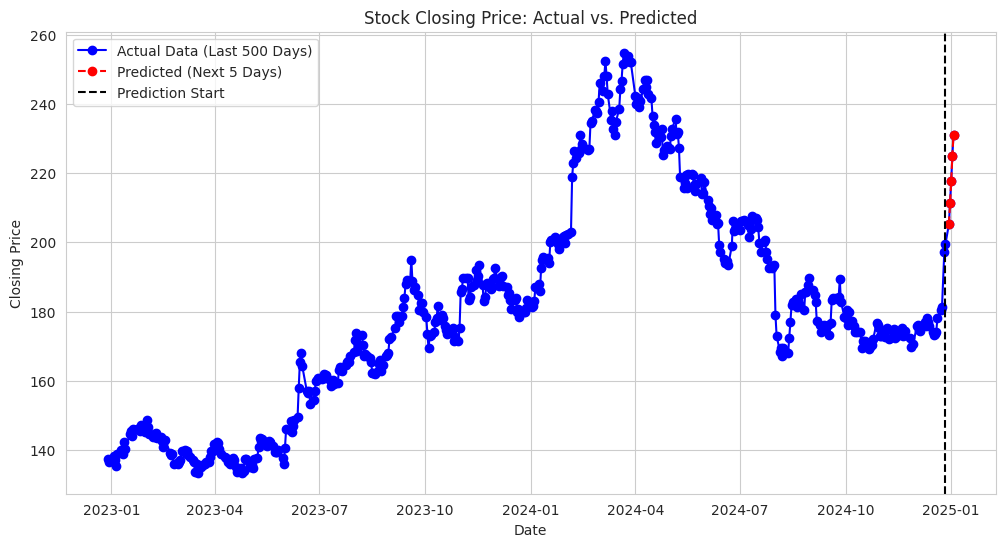

In [30]:
plot_df = pd.concat([df_full[["Close"]].iloc[-500:], future_df[["Close"]]])  
# Plot actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df["Close"], marker="o", label="Actual Data (Last 500 Days)", color="blue")
plt.plot(future_df.index, future_df["Close"], marker="o", linestyle="dashed", label="Predicted (Next 5 Days)", color="red")

# Labels and legend
plt.axvline(df_full.index[-1], color="black", linestyle="--", label="Prediction Start")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Closing Price: Actual vs. Predicted")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# Save results to a CSV file
future_df[["Close"]].to_csv("predicted_future_closing_prices.csv", index=True)
